## Machine learning analysis on the Salary Prediction Dataset 

Class: CS479 Data Science 

Assignment: 4, Final Project

## Overview 

For this analysis, we will break it into a couple of sections: 
- An initial look at the dataset, using tools from sklearn module in python
- Semantical analysis, comparing the job description category and the predicted salary
- Analysis of the dataset using a very powerful tool - PyTorch 
- Visualization of the results throughout 

### 1. Data Loading and Preprocessing:   
- We'll load the dataset from Kaggle into a pandas dataframe, inspect it, handle missing values, and preprocess it for modeling. For preprocessing, we will handle missing values, encode categorical variables, and split the data into training and testing set

### 2. Feature Engineering: 
- We'll extract relevant features and transform categorical variables into numerical representations.

### 3. Model Selection: 
- We'll choose a few machine learning algorithms suitable for regression tasks, such as Decision Trees, Random Forests, and Gradient Boosting.

### 4. Model Training: 
- We'll train these models on our dataset.

### 5. Model Evaluation: 
- We'll evaluate the performance of each model and select the best one based on certain metrics.

### 6. Prediction: 
- We'll use the chosen model to predict salaries for new data.

In [1]:
# Import necessary libraries for this project 
import pandas as pd
from sklearn.model_selection import train_test_split,learning_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso
from scipy.sparse import hstack
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

## Initial evaluation of data using existing pre built models

Random Forest:
MSE: 0.7010610738255011
R^2: 0.9992872695501703

Gradient Boosting:
MSE: 0.43110203225049093
R^2: 0.9995617221425634

Support Vector Machine:
MSE: 925.1585798459794
R^2: 0.05944187261840561

Decision Tree:
MSE: 4.026845637583893
R^2: 0.9959061262851054

K-Nearest Neighbors:
MSE: 704.4389261744966
R^2: 0.28383547243577434

Ridge Regression:
MSE: 32.51326795304314
R^2: 0.9669455387571919

Lasso Regression:
MSE: 0.5022882182485627
R^2: 0.9994893510407261



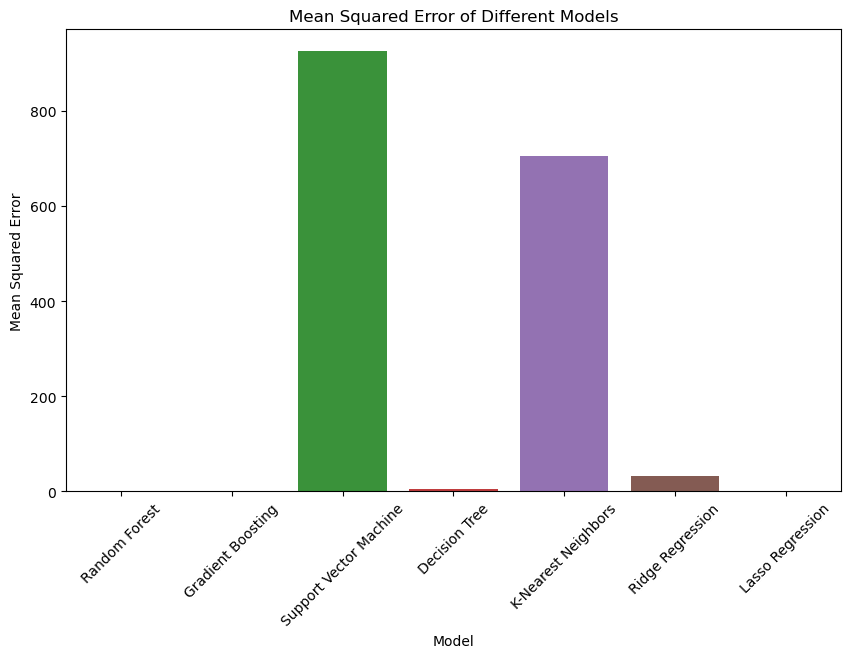

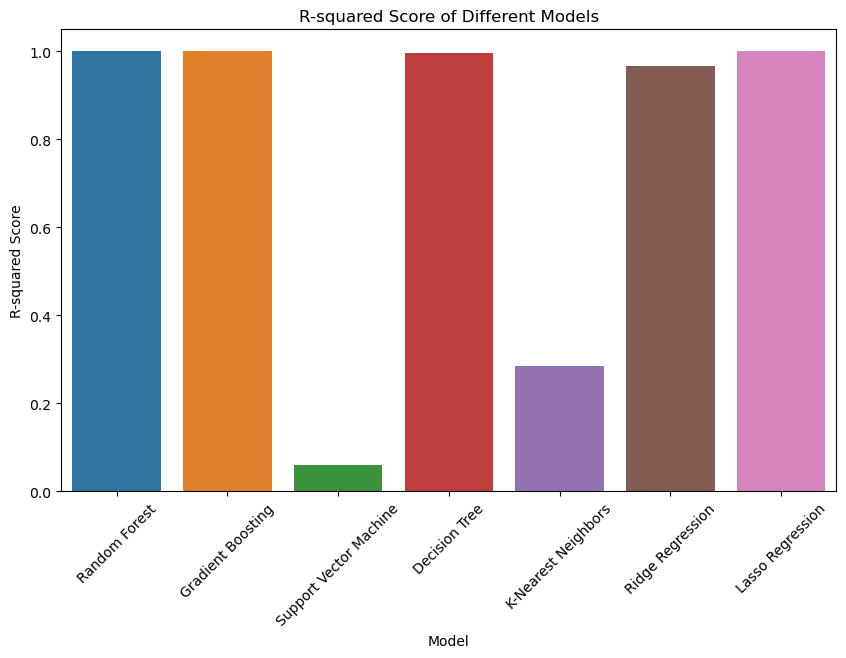

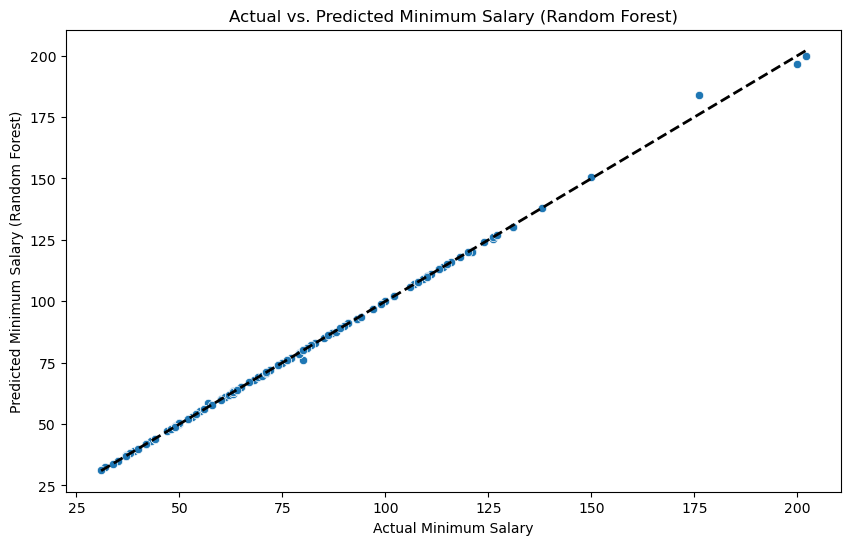

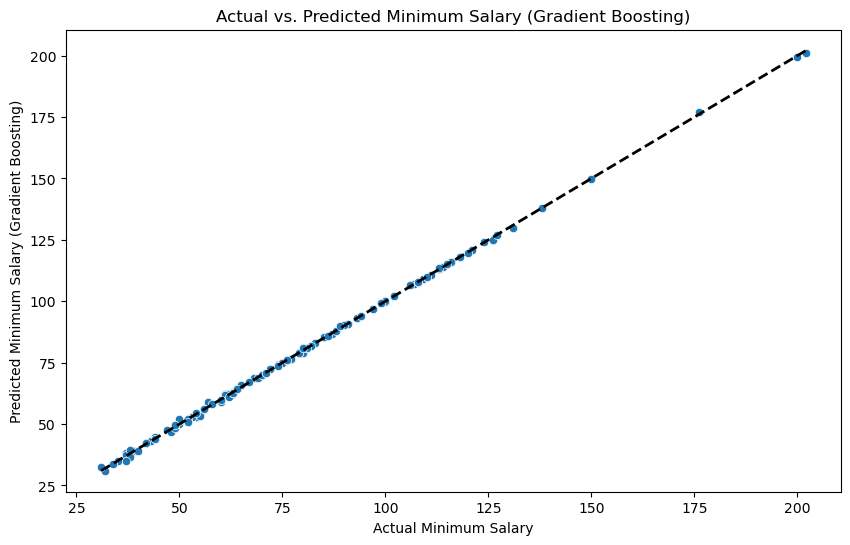

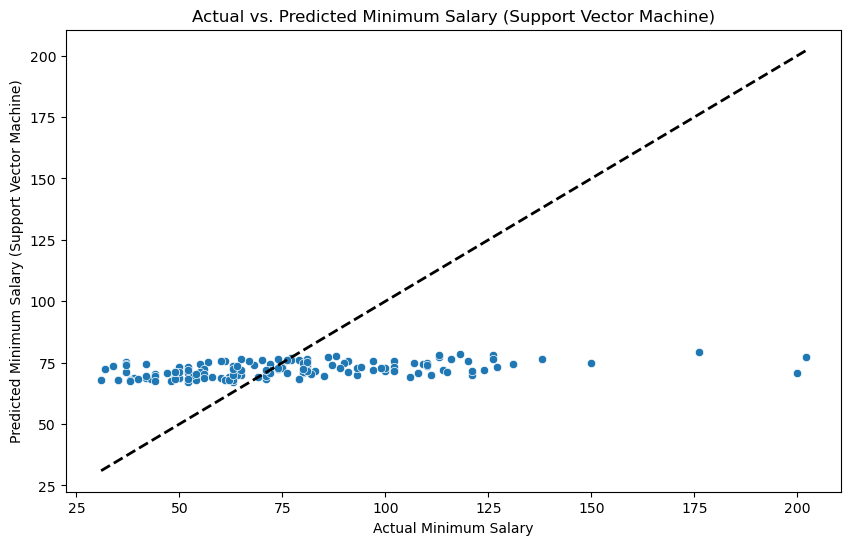

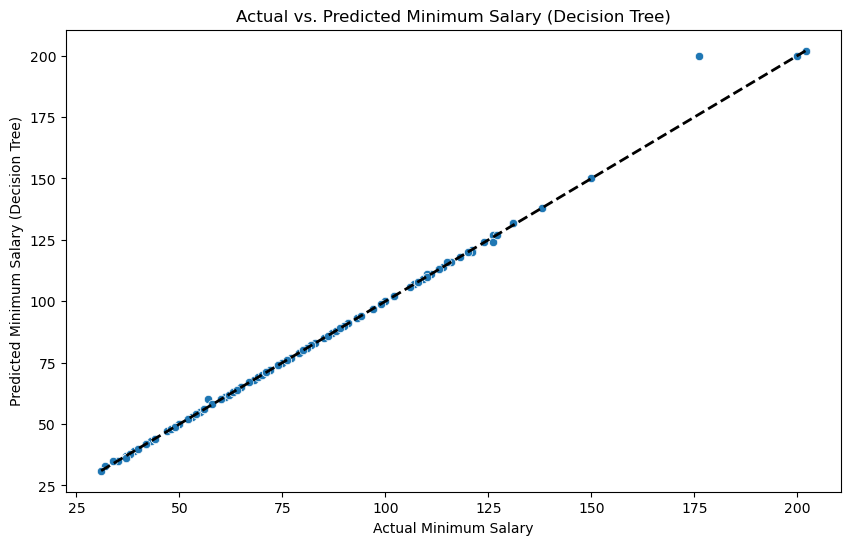

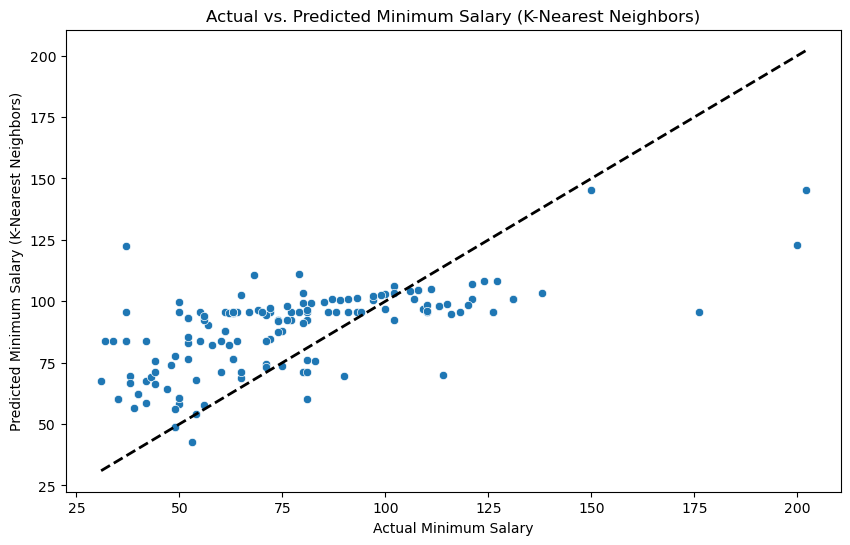

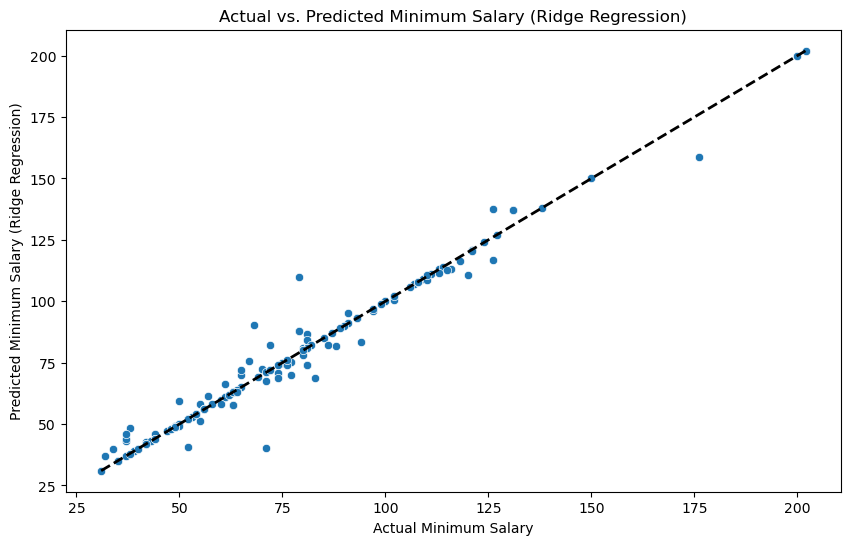

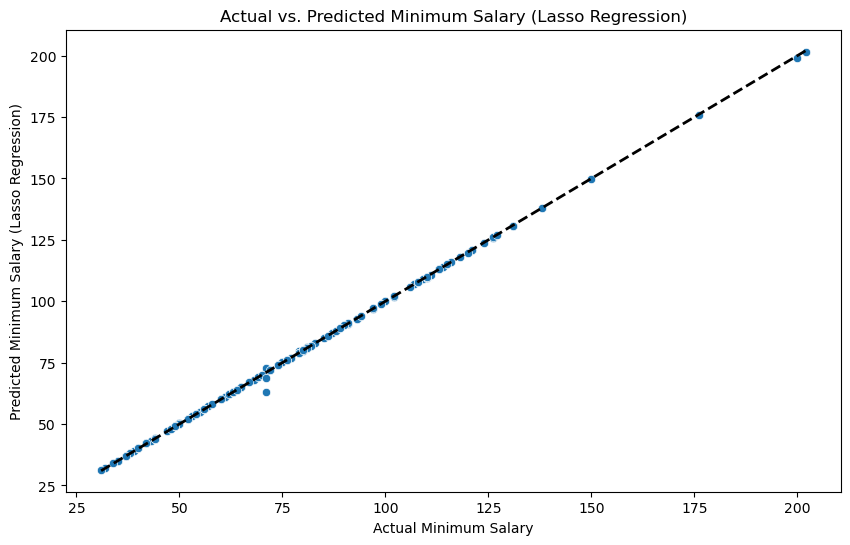

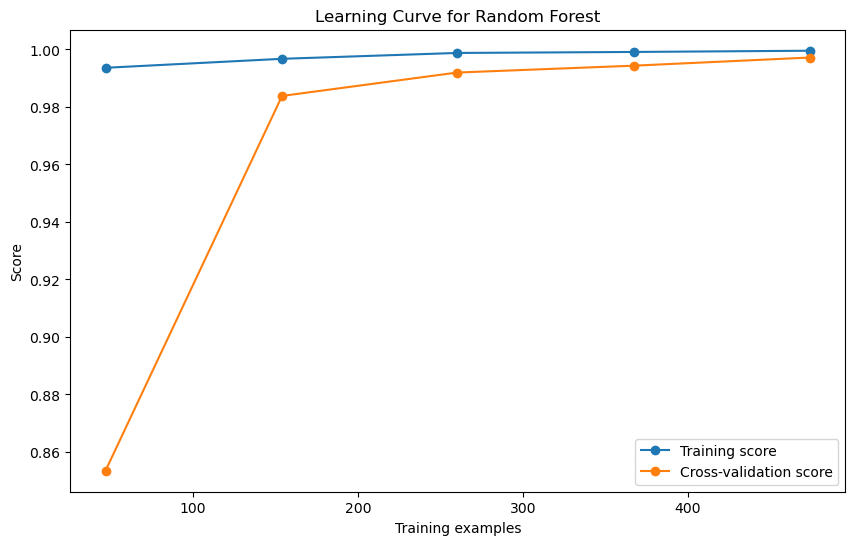

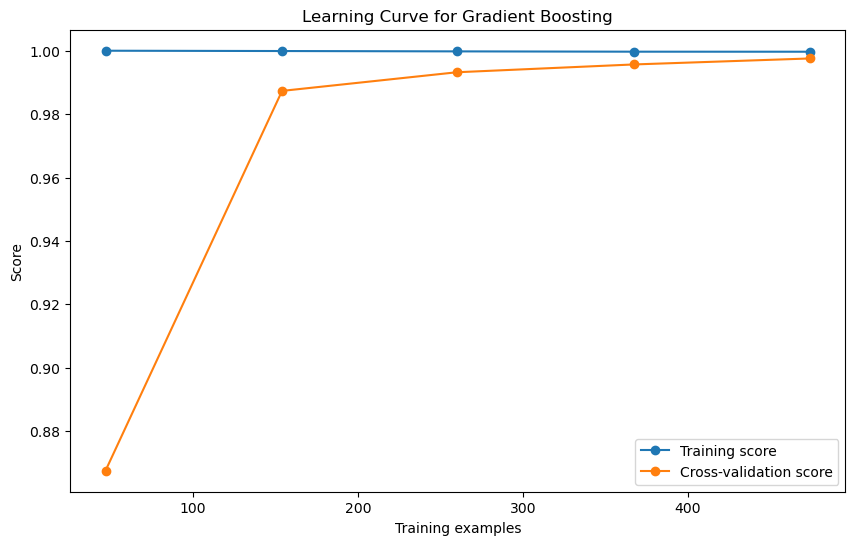

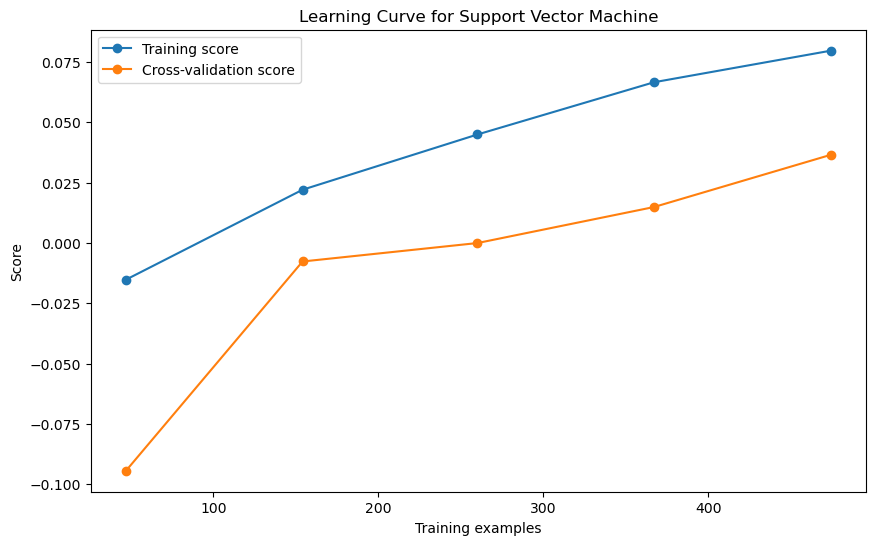

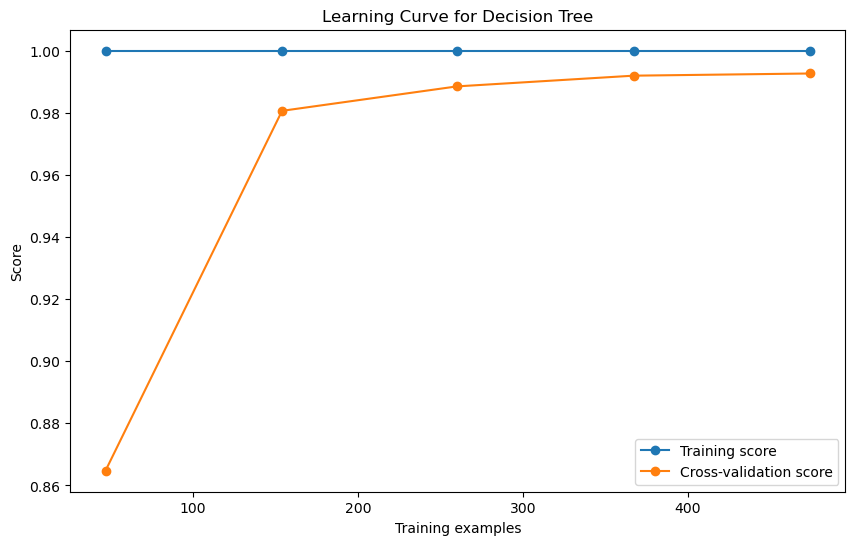

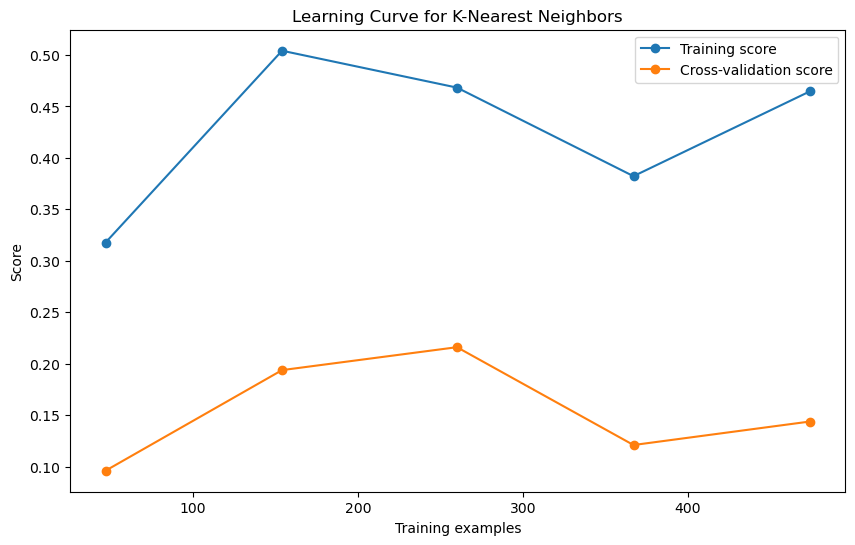

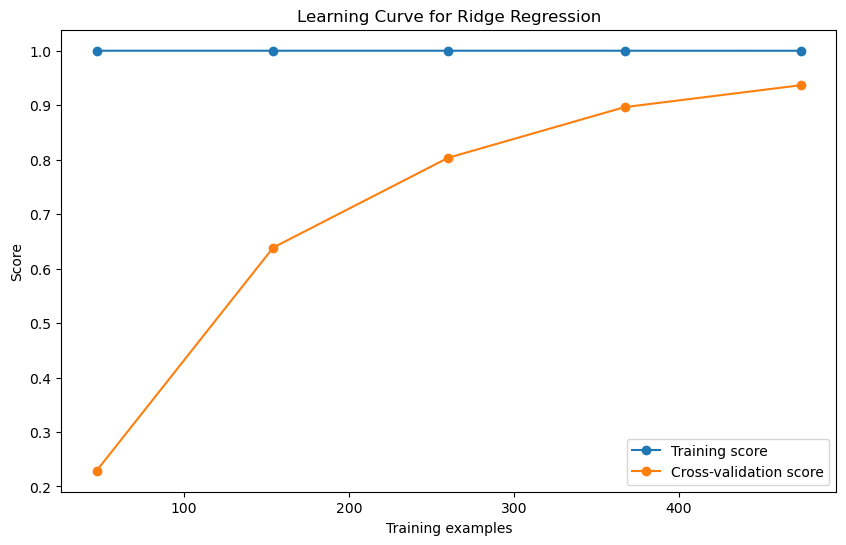

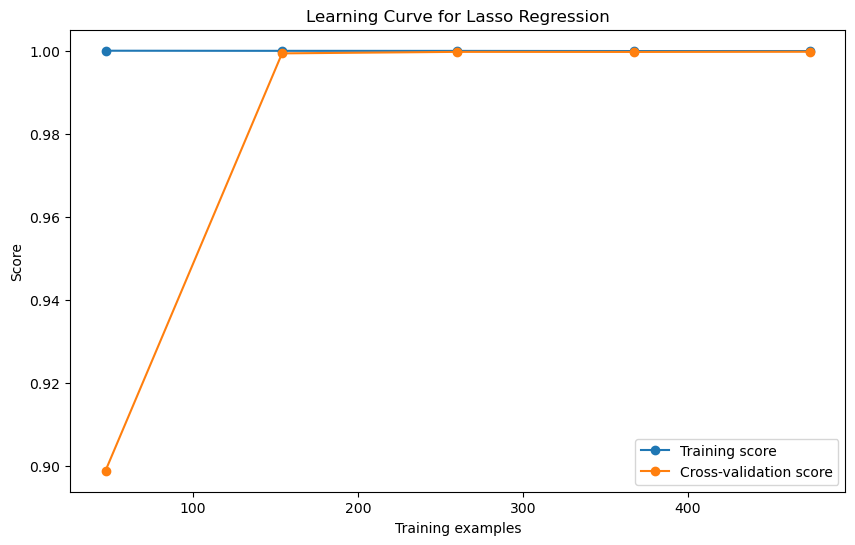

In [27]:
# Load dataset
data = pd.read_csv("salary_data_cleaned.csv")

# Data Preprocessing
# Drop irrelevant columns
data.drop(['Job Description'], axis=1, inplace=True)

# Handling missing values
data.dropna(inplace=True)

# Extracting minimum and maximum salary estimates from 'Salary Estimate' column
data[['Min Salary', 'Max Salary']] = data['Salary Estimate'].str.extract(r'\$(\d+)K-\$(\d+)K')

# Handling missing values in 'Min Salary' and 'Max Salary' columns
data['Min Salary'] = data['Min Salary'].fillna(data['Min Salary'].median())
data['Max Salary'] = data['Max Salary'].fillna(data['Max Salary'].median())

# Converting the extracted values to numeric data type
data['Min Salary'] = data['Min Salary'].astype(int)
data['Max Salary'] = data['Max Salary'].astype(int)

# Dropping the original 'Salary Estimate' column
data.drop(columns=['Salary Estimate'], inplace=True)

# Encoding ordinal categorical variables
ordinal_encoder = LabelEncoder()
data['Size'] = ordinal_encoder.fit_transform(data['Size'])
data['Type of ownership'] = ordinal_encoder.fit_transform(data['Type of ownership'])
data['Revenue'] = ordinal_encoder.fit_transform(data['Revenue'])

# One-hot encoding for nominal categorical variables
nominal_cols = ['Job Title', 'Company Name', 'Location', 'Headquarters', 'Industry', 'Sector', 'Competitors', 'company_txt', 'job_state']
data = pd.get_dummies(data, columns=nominal_cols)

# Splitting data into features and target variable
X = data.drop(columns=['Min Salary'])  # Dropping the salary columns from features
y = data['Min Salary']  # Assuming we use 'Min Salary' as the target variable

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Training various machine learning models
models = {
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "Support Vector Machine": SVR(),
    "Decision Tree": DecisionTreeRegressor(),
    "K-Nearest Neighbors": KNeighborsRegressor(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1)
}

results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MSE': mse, 'R^2': r2, 'Predictions': y_pred}

# Displaying results
for name, result in results.items():
    print(f"{name}:")
    print(f"MSE: {result['MSE']}")
    print(f"R^2: {result['R^2']}")
    print()

# Visualizing results
plt.figure(figsize=(10, 6))
sns.barplot(x=list(results.keys()), y=[result['MSE'] for result in results.values()])
plt.title('Mean Squared Error of Different Models')
plt.xlabel('Model')
plt.ylabel('Mean Squared Error')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x=list(results.keys()), y=[result['R^2'] for result in results.values()])
plt.title('R-squared Score of Different Models')
plt.xlabel('Model')
plt.ylabel('R-squared Score')
plt.xticks(rotation=45)
plt.show()

for name, result in results.items():
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_test, y=result['Predictions'])
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.xlabel('Actual Minimum Salary')
    plt.ylabel(f'Predicted Minimum Salary ({name})')
    plt.title(f'Actual vs. Predicted Minimum Salary ({name})')
    plt.show()

for name, model in models.items():
    train_sizes, train_scores, test_scores = learning_curve(model, X_train_scaled, y_train, cv=5)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', label='Cross-validation score')
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    plt.title(f'Learning Curve for {name}')
    plt.legend()
    plt.show()

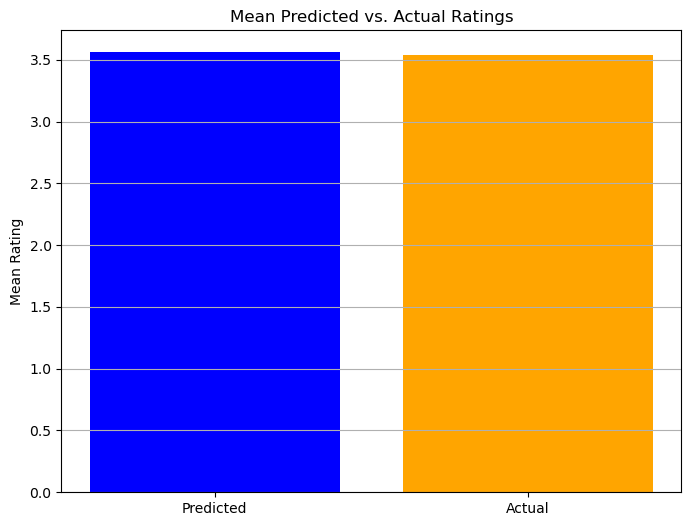

In [ ]:
# Convert tensors to numpy arrays
predictions_np = predictions.squeeze().numpy()  # Squeeze to remove extra dimensions
y_test_np = y_test_tensor.squeeze().numpy()     # Squeeze to remove extra dimensions

# Calculate mean predicted and actual ratings
mean_predicted_rating = predictions_np.mean()
mean_actual_rating = y_test_np.mean()

# Plot mean predicted and actual ratings
plt.figure(figsize=(8, 6))
plt.bar(['Predicted', 'Actual'], [mean_predicted_rating, mean_actual_rating], color=['blue', 'orange'])
plt.title('Mean Predicted vs. Actual Ratings')
plt.ylabel('Mean Rating')
plt.grid(axis='y')
plt.show()

In [3]:
# Download required nltk resources (if needed)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/dawsonburgess/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dawsonburgess/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/dawsonburgess/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/dawsonburgess/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Performing semantical analysis 
### to see if there is a correlcation between certain keywords in job description, and higher minimum salary

In [4]:
# Load the dataset
data = pd.read_csv("salary_data_cleaned.csv")

# Extracting minimum and maximum salary estimates from 'Salary Estimate' column
data[['Min Salary', 'Max Salary']] = data['Salary Estimate'].str.extract(r'\$(\d+)K-\$(\d+)K')

# Handling missing values in 'Min Salary' and 'Max Salary' columns
data['Min Salary'] = data['Min Salary'].fillna(data['Min Salary'].median())
data['Max Salary'] = data['Max Salary'].fillna(data['Max Salary'].median())

# Converting the extracted values to numeric data type
data['Min Salary'] = data['Min Salary'].astype(int)
data['Max Salary'] = data['Max Salary'].astype(int)

# Dropping the original 'Salary Estimate' column
data.drop(columns=['Salary Estimate'], inplace=True)

# Text Preprocessing
job_descriptions = data['Job Description'].fillna('')  # Handle missing values

# Function for text preprocessing
def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text.lower())

    # Remove punctuation
    tokens = [word for word in tokens if word not in string.punctuation]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join tokens back into text
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

# Apply text preprocessing to job descriptions
job_descriptions_preprocessed = job_descriptions.apply(preprocess_text)

# Feature Extraction
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X = tfidf_vectorizer.fit_transform(job_descriptions_preprocessed)

# Statistical Analysis
model = LinearRegression()
model.fit(X, data['Min Salary'])  # Using 'Min Salary' as the target variable
coefficients = pd.Series(model.coef_, index=tfidf_vectorizer.get_feature_names_out())

# Visualize the coefficients or perform further analysis as needed
print("Results from Linear Regression")
print(coefficients.nlargest(10))  # Print top 10 words with the highest coefficients
print() # newline 

# Random Forest Regression
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, data['Min Salary'])

# Feature Importance
feature_importance = pd.Series(rf_model.feature_importances_, index=tfidf_vectorizer.get_feature_names_out())

# Visualize the feature importance or perform further analysis as needed
print("Results from Random Forest Regression model")
print(feature_importance.nlargest(10))  # Print top 10 words with the highest feature importance

Results from Linear Regression
senior          758.651511
five            134.282064
control         122.029159
view            114.347030
prior           106.810271
release         105.544358
platform        103.974613
principal       103.915949
optimization    103.749594
mentor          103.627288
dtype: float64

Results from Random Forest Regression model
machine           0.109130
predictive        0.034019
model             0.028670
learning          0.024588
give              0.023836
infrastructure    0.022845
scientist         0.021209
san               0.020103
expression        0.015859
product           0.014615
dtype: float64


## Results from linear regression model: 
1. Senior (758.65): This indicates that the presence of the word "senior" in the job descriptions has the highest positive impact on the predicted minimum salary. Job descriptions mentioning "senior" likely correspond to positions with higher salaries, as senior roles often require more experience and expertise.

2. Five (134.28): The word "five" appearing in job descriptions may be associated with specific qualifications or requirements, potentially indicating roles with higher levels of responsibility or experience, thus contributing positively to the predicted salary.

3. Control (122.03): Job descriptions mentioning "control" could be related to positions that involve managing or overseeing processes or systems, which may typically command higher salaries due to the level of responsibility.

4. View (114.35): The presence of "view" in job descriptions could be related to aspects such as data visualization or reporting, indicating roles with analytical or technical skills, which are often associated with higher salaries.

4. Prior (106.81): Mention of "prior" suggests that previous experience or knowledge is required for the role, which may correlate with higher salary expectations for positions that demand specific expertise or skills.

5. Release (105.54): This word may be associated with software development or project management roles, indicating involvement in the release process of products or projects, which could be indicative of higher-level roles.

6. Platform (103.97): Presence of "platform" in job descriptions could relate to roles involving development or management of software platforms or frameworks, which are typically associated with higher salaries due to the technical expertise required.

7. Principal (103.92): Mention of "principal" may indicate senior or leadership roles within an organization, which often come with higher levels of responsibility and hence higher salaries.

8. Optimization (103.75): Job descriptions mentioning "optimization" may relate to roles in data science, analytics, or operations, indicating a focus on improving efficiency or performance, which could command higher salaries.

9. Mentor (103.63): This suggests that roles involving mentoring or leadership responsibilities are associated with higher salaries, as mentoring often requires significant experience and expertise.

Overall, the coefficients provide insight into how each word contributes to the prediction of minimum salaries based on the job descriptions. Words with higher coefficients are likely to have a stronger influence on the predicted salary.

## Results from Random Forest Regression model: 
1. Machine (0.109130): This feature (word) has the highest importance score. In the context of job descriptions, the word "machine" appears to be strongly correlated with variations in minimum salary. Jobs that mention "machine" may involve roles related to machine learning, artificial intelligence, or other technical fields, which typically command higher salaries.

2. Predictive (0.034019): The word "predictive" also has a significant importance score. Job descriptions mentioning "predictive" likely involve roles that require skills in predictive analytics or modeling, which are in demand and often associated with higher salaries.

3. Model (0.028670): The term "model" is another important feature. It suggests that job descriptions referencing models, such as predictive models or machine learning models, are correlated with variations in minimum salary.

4. Learning (0.024588): The word "learning" is also relevant, indicating roles related to machine learning or continuous learning and development, which may command higher salaries due to the specialized skills required.

5. Give (0.023836): This feature may represent roles that involve giving presentations, reports, or insights, which could be indicative of higher-level positions with leadership or communication responsibilities.

6. Infrastructure (0.022845): Jobs mentioning "infrastructure" may involve responsibilities related to the development or management of technical infrastructure, which are often associated with higher salaries due to the specialized expertise required.

7. Scientist (0.021209): The term "scientist" suggests roles related to data science or research, which are typically high-paying positions due to the specialized skills and expertise involved.

8. San (0.020103): This feature may represent locations such as San Francisco, which is known for its high cost of living and typically offers higher salaries compared to other locations.

9. Expression (0.015859): Jobs mentioning "expression" may involve roles related to data visualization, storytelling, or communication, which could be indicative of higher-level positions with specialized skills.

10. Product (0.014615): The word "product" suggests roles related to product development or management, which often require specialized skills and experience and may command higher salaries.

Overall, these feature importance scores provide insights into which words or features in job descriptions are most influential in predicting variations in minimum salary. Words with higher importance scores are likely to have a stronger influence on the predicted salary.

## Training a custom NN model 

In [19]:
# Load the dataset
data = pd.read_csv("salary_data_cleaned.csv").dropna()
X = data[['Rating', 'Founded']].values.astype(np.float32)
y = data['Rating'].values.astype(np.float32)

# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train).unsqueeze(1)  # Convert to column tensor
X_test_tensor = torch.tensor(X_test)
y_test_tensor = torch.tensor(y_test).unsqueeze(1)    # Convert to column tensor

# Step 2: Define the Neural Network Architecture
class RatingPredictor(nn.Module):
    def __init__(self, input_size):
        super(RatingPredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 8)

    def forward(self, x):
        # Ensure the input tensor matches the expected input size
        if x.dim() == 1:
            x = x.unsqueeze(0)  # Add a batch dimension if input is 1D
        
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))

        return x

# Step 3: Model Training
model = RatingPredictor(input_size=X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Step 4: Model Evaluation
with torch.no_grad():
    predictions = model(X_test_tensor)
    mse = criterion(predictions, y_test_tensor)
    print(f'Mean Squared Error on Test Data: {mse.item():.4f}')

/Users/dawsonburgess/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([593, 1])) that is different to the input size (torch.Size([593, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/1000], Loss: 13.1312
Epoch [20/1000], Loss: 12.7233
Epoch [30/1000], Loss: 12.2424
Epoch [40/1000], Loss: 11.6680
Epoch [50/1000], Loss: 10.9057
Epoch [60/1000], Loss: 9.9511
Epoch [70/1000], Loss: 8.8857
Epoch [80/1000], Loss: 7.7470
Epoch [90/1000], Loss: 6.5782
Epoch [100/1000], Loss: 5.4357
Epoch [110/1000], Loss: 4.3950
Epoch [120/1000], Loss: 3.5293
Epoch [130/1000], Loss: 2.8830
Epoch [140/1000], Loss: 2.4059
Epoch [150/1000], Loss: 1.7706
Epoch [160/1000], Loss: 1.2348
Epoch [170/1000], Loss: 0.8616
Epoch [180/1000], Loss: 0.6079
Epoch [190/1000], Loss: 0.4341
Epoch [200/1000], Loss: 0.3070
Epoch [210/1000], Loss: 0.2179
Epoch [220/1000], Loss: 0.1626
Epoch [230/1000], Loss: 0.1301
Epoch [240/1000], Loss: 0.1107
Epoch [250/1000], Loss: 0.0975
Epoch [260/1000], Loss: 0.0870
Epoch [270/1000], Loss: 0.0788
Epoch [280/1000], Loss: 0.0719
Epoch [290/1000], Loss: 0.0663
Epoch [300/1000], Loss: 0.0616
Epoch [310/1000], Loss: 0.0577
Epoch [320/1000], Loss: 0.0543
Epoch [330/1

/Users/dawsonburgess/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([149, 1])) that is different to the input size (torch.Size([149, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


## 1. Epoch [X/Y], Loss: Z: 
- This line indicates the progress of the training process. "Epoch [X/Y]" means the model has completed epoch X out of Y total epochs. "Loss: Z" represents the current value of the loss function (mean squared error in this case) calculated on the training data. The loss typically decreases over epochs as the model learns to make better predictions.


## 2. Mean Squared Error on Test Data: W: 
- After training completes, you evaluate the trained model on the test data to assess its performance. The mean squared error (MSE) on the test data is a measure of how well the model's predictions match the actual values in the test set. A lower MSE indicates better performance, as it means the model's predictions are closer to the actual values.


In summary, this model achieved a mean squared error ranging from 3 to 0.0285 on the test data, which indicates that, on average, the squared difference between the predicted ratings and the actual ratings in the test set is this value. This suggests that the model has learned to make reasonably accurate predictions on unseen data.

## Mean Prediciton vs Actual Ratings

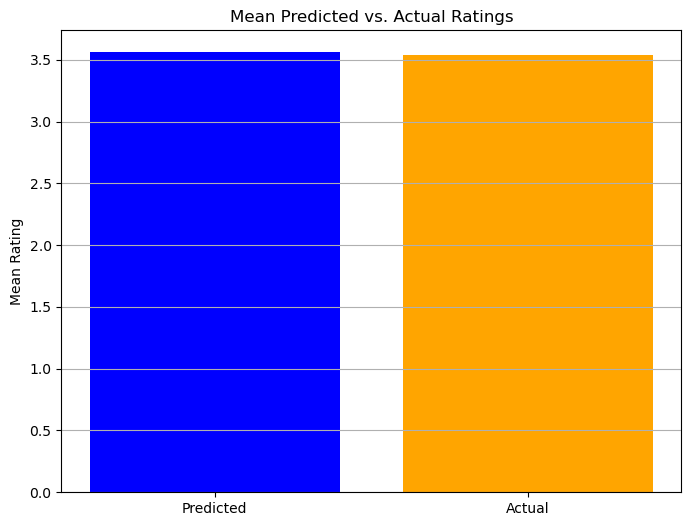

In [20]:
# Convert tensors to numpy arrays
predictions_np = predictions.squeeze().numpy()  # Squeeze to remove extra dimensions
y_test_np = y_test_tensor.squeeze().numpy()     # Squeeze to remove extra dimensions

# Calculate mean predicted and actual ratings
mean_predicted_rating = predictions_np.mean()
mean_actual_rating = y_test_np.mean()

# Plot mean predicted and actual ratings
plt.figure(figsize=(8, 6))
plt.bar(['Predicted', 'Actual'], [mean_predicted_rating, mean_actual_rating], color=['blue', 'orange'])
plt.title('Mean Predicted vs. Actual Ratings')
plt.ylabel('Mean Rating')
plt.grid(axis='y')
plt.show()

## Distribution of Predicted vs Actual Ratings

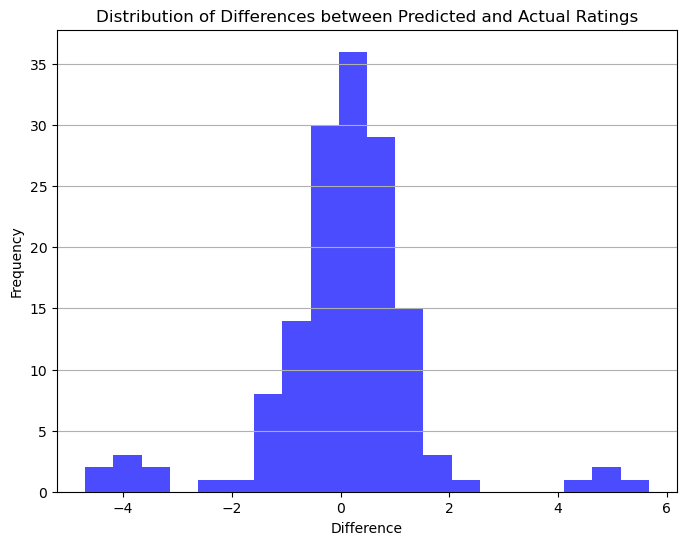

In [21]:
# Flatten predictions array
predictions_flat = predictions_np.flatten()

# Ensure both arrays have the same length
min_length = min(len(predictions_flat), len(y_test_np))
predictions_flat = predictions_flat[:min_length]
y_test_np = y_test_np[:min_length]

# Calculate differences between predicted and actual ratings
differences = predictions_flat - y_test_np

# Plot histogram of differences
plt.figure(figsize=(8, 6))
plt.hist(differences, bins=20, color='blue', alpha=0.7)
plt.title('Distribution of Differences between Predicted and Actual Ratings')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

/Users/dawsonburgess/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([100, 1])) that is different to the input size (torch.Size([100, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/dawsonburgess/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([149, 1])) that is different to the input size (torch.Size([149, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/dawsonburgess/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([200, 1])) that is different to the input size (torch.Size([200, 8])). This will likely lead to incorrect results du

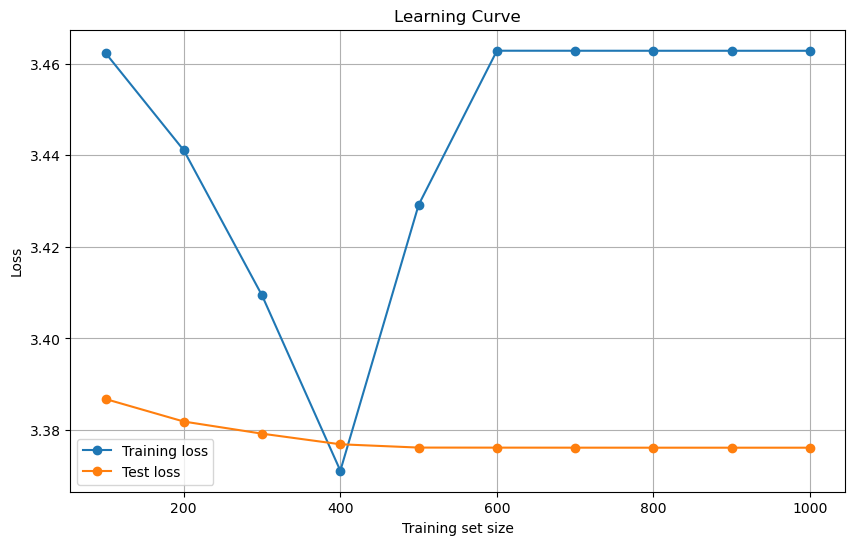

In [22]:
train_sizes = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]  # Specify different training set sizes
train_losses = []
test_losses = []

# Define the model outside the loop
model = RatingPredictor(input_size=X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for size in train_sizes:
    # Use a subset of the training data with the specified size
    X_subset = X_train_tensor[:size]
    y_subset = y_train_tensor[:size]
    
    # Train the model
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(X_subset)
        loss = criterion(outputs, y_subset)
        loss.backward()
        optimizer.step()
    
    # Evaluate the model on the training and test sets
    with torch.no_grad():
        train_predictions = model(X_subset)
        train_loss = criterion(train_predictions, y_subset).item()
        test_predictions = model(X_test_tensor)
        test_loss = criterion(test_predictions, y_test_tensor).item()
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_losses, 'o-', label='Training loss')
plt.plot(train_sizes, test_losses, 'o-', label='Test loss')
plt.xlabel('Training set size')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()


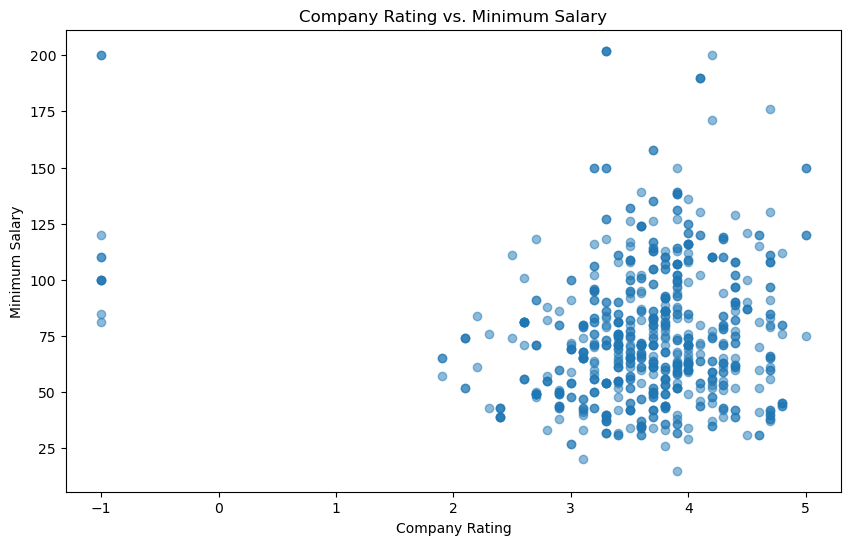

Mean Squared Error: 903.786123776633
R-squared Score: 0.08117008024178429


In [33]:
# Load the dataset
data = pd.read_csv("salary_data_cleaned.csv").dropna()

# Extracting minimum and maximum salary estimates from 'Salary Estimate' column
data[['Min Salary', 'Max Salary']] = data['Salary Estimate'].str.extract(r'\$(\d+)K-\$(\d+)K')

# Handling missing values in 'Min Salary' and 'Max Salary' columns
data['Min Salary'] = data['Min Salary'].fillna(data['Min Salary'].median())
data['Max Salary'] = data['Max Salary'].fillna(data['Max Salary'].median())

# Converting the extracted values to numeric data type
data['Min Salary'] = data['Min Salary'].astype(int)
data['Max Salary'] = data['Max Salary'].astype(int)

# Dropping the original 'Salary Estimate' column
data.drop(columns=['Salary Estimate'], inplace=True)

# Select relevant columns
X = data[['Rating']].values.astype(np.float32)
y = data['Min Salary'].values.astype(np.float32)

# Visualize the relationship between company rating and minimum salary
plt.figure(figsize=(10, 6))
plt.scatter(X, y, alpha=0.5)
plt.title('Company Rating vs. Minimum Salary')
plt.xlabel('Company Rating')
plt.ylabel('Minimum Salary')
plt.show()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model training
model = RandomForestRegressor()
model.fit(X_train_scaled, y_train)

# Model evaluation
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared Score:", r2)